# K-means clustering

For this week's assignment, you will implement a *clustering* algorithm called K-means. Up to this point, all the algorithms we've covered have been *supervised learning*, but clustering is a form of *unsupervised learning*. In unsupervised learning, there is no target variable we are trying to approximate. Instead, we are trying to extract some kind of pattern from the data, where the type of pattern depends on the algorithm we use. In the case of clustering, we are looking for *clusters* or groupings within the data.

We will work with a classic dataset from machine learning; Fisher's Iris dataset. The dataset contains the measurements of *length* and *width* of the *sepals* and *petals* of 150 flowers. 

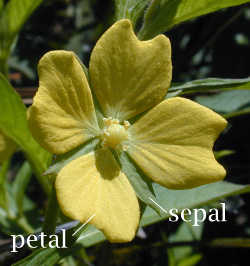

The dataset contains 4 attributes for each flower; *length* and *width* of both *sepals* and *petals*. In addition, this data set also actually contains the supervised label of the species of Iris, but we will completely **ignore that part of the data set for this assignment**. So the assignment we're trying to solve is to find out how these 4 properties are distributed for all these 150 flowers, and if we can find any groupings of points that are sufficiently similar that we might consider them to be their own species.

The Iris dataset is such a classic example that it even comes included in `seaborn`, and so can easily be loaded with the code below:

In [1]:
from notebook_checker import start_checks
# Start automatic globals checks
%start_checks

In [2]:
%matplotlib inline

import math
import matplotlib.pylab as plt
import numpy as np
import seaborn as sns

# Load the data set
df_iris = sns.load_dataset('iris')

# Remove the target variable
df_iris = df_iris.drop('species', axis=1)

display(df_iris)

,sepal_length,sepal_width,petal_length,petal_width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
...,...,...,...,...
145,6.7,3.0,5.2,2.3
146,6.3,2.5,5.0,1.9
147,6.5,3.0,5.2,2.0
148,6.2,3.4,5.4,2.3


### Exploration

Let's plot this data, so we can see what it looks like. Below is some seaborn code that plots a so-called scatter matrix. This is a grid of scatter plots that can be used to easily identify correlations and see the separability of the dataset. The diagonals of this plot show how the data is distributed for every *single* feature, while the non-diagonals show scatter plots using *two* of the features as the $x$ and $y$ axis, with all the different possible configurations shown in the grid.

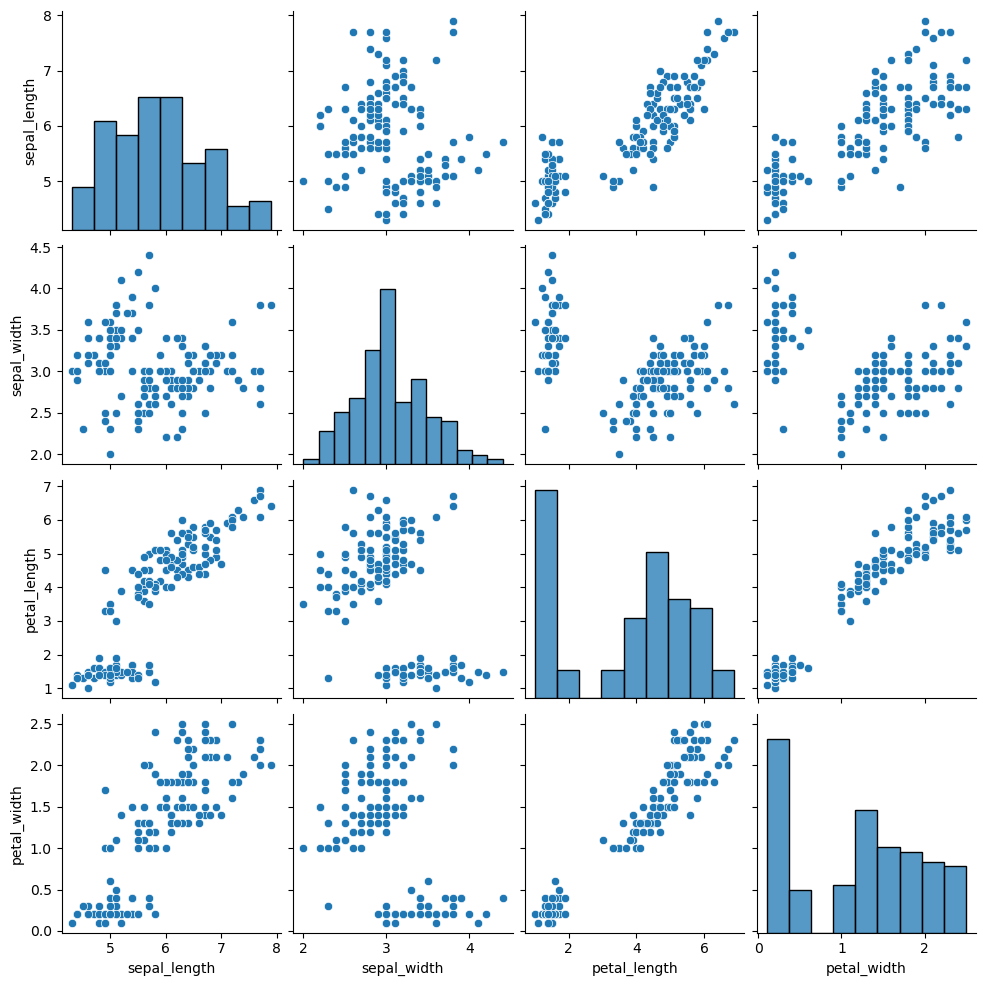

In [3]:
sns.pairplot(df_iris)

plt.show()

This type of graphic is a nice way to visually explore what the data set looks like, and to determine what features might be useful. Normally, if you were to solve this clustering problem, you would probably just use all 4 features to determine the clusters. However, the goal of this assignment is to understand clustering algorithms, so having clear visuals will be essential. For this reason, we'll select 2 features to use, so we can make nice 2-dimensional plots containing all the features. From the plot above, it seems like `petal_length` and `petal_width` are the most distinctive features, so we'll use those.

**Note:** Although we will only be working with 2 features, all functions and code for this assignment should work with *any* number of features.

In [4]:
data = df_iris.drop(['sepal_length', 'sepal_width'], axis=1).to_numpy()

print(data)

[[1.4 0.2]
 [1.4 0.2]
 [1.3 0.2]
 [1.5 0.2]
 [1.4 0.2]
 [1.7 0.4]
 [1.4 0.3]
 [1.5 0.2]
 [1.4 0.2]
 [1.5 0.1]
 [1.5 0.2]
 [1.6 0.2]
 [1.4 0.1]
 [1.1 0.1]
 [1.2 0.2]
 [1.5 0.4]
 [1.3 0.4]
 [1.4 0.3]
 [1.7 0.3]
 [1.5 0.3]
 [1.7 0.2]
 [1.5 0.4]
 [1.  0.2]
 [1.7 0.5]
 [1.9 0.2]
 [1.6 0.2]
 [1.6 0.4]
 [1.5 0.2]
 [1.4 0.2]
 [1.6 0.2]
 [1.6 0.2]
 [1.5 0.4]
 [1.5 0.1]
 [1.4 0.2]
 [1.5 0.2]
 [1.2 0.2]
 [1.3 0.2]
 [1.4 0.1]
 [1.3 0.2]
 [1.5 0.2]
 [1.3 0.3]
 [1.3 0.3]
 [1.3 0.2]
 [1.6 0.6]
 [1.9 0.4]
 [1.4 0.3]
 [1.6 0.2]
 [1.4 0.2]
 [1.5 0.2]
 [1.4 0.2]
 [4.7 1.4]
 [4.5 1.5]
 [4.9 1.5]
 [4.  1.3]
 [4.6 1.5]
 [4.5 1.3]
 [4.7 1.6]
 [3.3 1. ]
 [4.6 1.3]
 [3.9 1.4]
 [3.5 1. ]
 [4.2 1.5]
 [4.  1. ]
 [4.7 1.4]
 [3.6 1.3]
 [4.4 1.4]
 [4.5 1.5]
 [4.1 1. ]
 [4.5 1.5]
 [3.9 1.1]
 [4.8 1.8]
 [4.  1.3]
 [4.9 1.5]
 [4.7 1.2]
 [4.3 1.3]
 [4.4 1.4]
 [4.8 1.4]
 [5.  1.7]
 [4.5 1.5]
 [3.5 1. ]
 [3.8 1.1]
 [3.7 1. ]
 [3.9 1.2]
 [5.1 1.6]
 [4.5 1.5]
 [4.5 1.6]
 [4.7 1.5]
 [4.4 1.3]
 [4.1 1.3]
 [4.  1.3]
 [4.4 1.2]

## K-means 

A modified version of the pseudo-code from the theory videos can be found below. In the theory videos, cluster assignments $c$ is a vector of length $m$ containing integers in the range $1$ to $k$, representing the assignment to a specific cluster for each sample. Here, this step will instead be encoded in a one-hot matrix $B$ of dimension $m \times k$, where the *hot* column indicates the assigned cluster for each sample. This change will make the equations and implementation of k-means a little easier.

### One-hot encoding

Any categorical feature, meaning values consisting of a distinct and finitely limited set of options, can be represented with a one-hot encoding. We could encode which cluster each sample belongs to by writing out the cluster index for each sample. In the example below there are 5 points, being assigned to 3 different clusters

$$c = \left[\begin{array}{c} 2 \\ 1 \\ 1 \\ 3 \\ 2 \end{array} \right]$$

However, what is often done in machine learning instead, is to represent these same labels in a one-hot matrix

$$ B = \left[\begin{array}{ccc}
0 & 1 & 0\\
1 & 0 & 0\\ 
1 & 0 & 0\\
0 & 0 & 1\\ 
0 & 1 & 0\\
\end{array} \right]$$

In this matrix $B$, the rows still correspond to each sample from the $c$ vector, but the columns now correspond to each of the clusters. All the values for a row are $0$, except for the column corresponding to the cluster of that sample, which will be $1$. So there is always exactly one value in a row that is *on* (or *hot*), and all the others are *off* (or *cold*), which is why it is called a *one-hot encoding*.

### The k-means algorithm

The general steps of this pseudocode are still the same as the description of the algorithm in the theory videos.

* Randomly initialize all $\mu_j$, with $j = 1, \dots, k$
* Until $\mu$ converges:
    * For all $x^i$, with $i = 1, \dots, m$
        * $b^i_j \leftarrow \left\{\begin{array}{ll} 1 & if\ dist(x^i,  \mu_j) \ =\ min_d\ dist(x^i, \mu_d)\\ 
            0 & otherwise \\ \end{array}\right.$
    * For all $\mu_j$, with $j = 1, \dots, k$
        * $\mu_j \leftarrow \sum_i b^i_j x^i / \sum_i b^i_j$

As this pseudo-code is a little dense, let's unpack all of the steps first:
    
#### 1. Initialize the cluster means

$$Randomly\ initialize\ all\ \mu_j,\ with\ j = 1, \dots, k$$

Initializing the cluster means creates a starting point for the algorithm. There are several ways you might create random starting points, but you usually select $k$ random points from $X$, which ensures that each of the means have sensible starting values for the data set you're working with.

#### 2. While not converged

$$Until\ \mu\ converges$$

This simply means the steps of k-means (2.1 and 2.2) are repeated until the cluster means no longer improve. It is actually possible to prove that this must occur at some point, i.e. that there can't be *cycles* in the sequence assignments or anything like that. You could use a cost function to detect that the centroids are no longer improving, but the most direct method is simply to compare the previous matrix $\mu$ with the current one, and see there was little or no change.

#### 2.1 Compute the new cluster assignment

This step creates one-hot encoding matrix $B$ containing the cluster assignments. The matrix is of dimension $m \times k$, where $m$ is the number of samples you are trying to cluster and $k$ is the number of clusters you are trying to find. The equation here, in a mathematical notation, constructs one individual entry $b^i_j$ of the whole matrix $B$:

$$b^i_j \leftarrow \left\{\begin{array}{ll} 1 & if\ dist(x^i,  \mu_j) \ =\ min_d\ dist(x^i, \mu_d)\\ 
            0 & otherwise \\ \end{array}\right.$$
            
So, $b^i$ is the one-hot encoded vector for the cluster assignment of point $x^i$, with the active column corresponding to the index of closest cluster mean. The matrix $B$ contains all the one-hot cluster-assignment vectors for every sample in the data set.

#### 2.2 Compute the new cluster means

This step creates the matrix $\mu$ containing all the cluster means, recomputed from the newly assigned samples. Each mean $\mu_j$ is a vector with $n$ elements, containing a mean value for each of the $n$ features in the data set. The whole matrix $\mu$ is therefore of dimension $k \times n$, where $k$ is the number of clusters you are trying to find and $n$ is the number of features each sample point in your data set has. The equation here constructs one mean vector $\mu_j$ from the sample vectors $x^i$ and the elements of the $B$ matrix:

$$\mu_j \leftarrow \frac{\sum_i b^i_j x^i}{\sum_i b^i_j}$$

As $x^i$ is a vector of features for a single sample, summing together all vectors gives a vector of totals for each feature. By multiplying with $b^i_j$, we filter out the samples that are not part of the $j^{th}$ cluster, as these will get multiplied by $0$. The samples that are actually assigned to the $j^{th}$ cluster get multiplied by $1$, so the result is a vector of totals for each feature, based on the samples assigned to the $j^{th}$ cluster.

Summing together $b^i_j$ for a specific $j$, ends up just counting how many samples there are assigned to that cluster. Dividing the vector of totals by this summed count therefore computes the mean vector for the cluster with index $j$.

### Assignment 1: Initializing the clusters

This is the first function we'll write for k-means. The function should randomly initialize `k` means, by selecting `k` random points from the `data`. This function should work with data of any dimensionality, e.g. not depend on there being specifically 2 or 4 features in the data set.

*Hint:* Here you would like to randomly draw $k$ points from the data, but want to avoid drawing the same point multiple times. Doing this operation with a loop actually becomes a lot more tricky, so finding a way to draw all k points with a single random operation will simplify the code a lot. Using something like [np.random.permutation](https://numpy.org/doc/stable/reference/random/generated/numpy.random.permutation.html) and some slicing might save a lot of time here.

In [5]:
def init_clusters(data, k):
    '''
    randomly initialize k means, by selecting k random points from the data
    '''
    
    # determine dimension of the data
    m_samples, n_features = data.shape
    
    # randomly initialize the k-means
    # shuffle data indices and slice the first k number of indices
    start_indices = np.random.permutation(m_samples)[:k]

    return data[start_indices]


In [7]:
assert init_clusters(data, 1).shape == (1,2), 'Does not create a single cluster of the correct shape'
assert init_clusters(data, 4).shape == (4,2), 'Does not correctly add multiple cluster means'
assert init_clusters(np.array([[1,2,3], [3, 2, 1]]), 2).shape == (2, 3), 'Does not correctly handle more that 2 features.'
print("Solution seems correct!")

Solution seems correct!


### Assignment 2: Computing the distance

This function should compute the *Euclidean* distance between 2 $n$-dimensional vectors `p` and `q`, which is defined as:

$$ dist(p,q) = \sqrt{\sum^n_{i=1}(p_i - q_i)^2} $$

Use the functions and techniques from the previous module to write this function without any loops.

In [8]:
def eucl_dist(p, q):
    '''
    Compute the Euclidean distance between 2 𝑛-dimensional vectors 
    '''
    
    return np.sqrt(np.sum(np.square(p - q)))


In [9]:
assert eucl_dist(np.array([3, 3]), np.array([1, 3])) == 2, 'Does not work correctly for a single feature'
assert eucl_dist(np.array([4, 2]), np.array([5, 1])) == math.sqrt(2), 'Does not work correctly for two features'
assert eucl_dist(np.array([1, 2, 3]), np.array([3, 2, 1])) == math.sqrt(8), 'Does not work correctly for more than 2 features'
print("Solution seems correct!")

Solution seems correct!


#### Vectorized Distance

In the code cell below we define a new function called `vectorized_distance` based on the `eucl_dist` function you just wrote. This function expands the distance function so it can take a matrix of points as the first argument, and a single point vector as the second argument. The function `vectorized_distance` then constructs the whole vector of distances, so from every point in the matrix to the other point, as a single operation. An example of how this new function can be used is also given below. Make sure you understand the example before moving to the next assignment, as you'll need to use this new function there.


In [10]:
vectorized_distance = np.vectorize(eucl_dist, signature='(n),(n)->()')

test_point_matrix = np.array([[0,0], [1, 0], [0, 2],  [1, 1], [2, 2]])
test_point_vector = np.array([0,0])

print("Testing points")
print(test_point_matrix)

print("Computing all distances to the point")
print(test_point_vector)

vector_of_distances = vectorized_distance(test_point_matrix, test_point_vector)

print("Resulting vector of distances")
print(vector_of_distances)


Testing points
[[0 0]
 [1 0]
 [0 2]
 [1 1]
 [2 2]]
Computing all distances to the point
[0 0]
Resulting vector of distances
[0.         1.         2.         1.41421356 2.82842712]


### Assignment 3: Cluster assignments

This function should compute the one-hot encoded matrix $B$ containing the assignments of `data` points to their nearest cluster `means`. The returned matrix should be of dimension $m \times k$, where $m$ is the number of samples you are clustering and $k$ is the number of cluster means you are considering for each cluster assignment. For a more detailed description, see k-means section 2.1 .

Write the function `cluster_assignment` such that it uses *just a single for-loop* to compute the one-hot matrix $B$, based on the `data` points and the cluster `means`. Think about what part of the function you can vectorize and then write a loop to repeat that to fill the matrix with ones in the right place. You can use the `vectorized_distance` function described above, and the Numpy built-in function [np.argmin](https://numpy.org/doc/stable/reference/generated/numpy.argmin.html) as part of your vectorization.

Note that this assignment will require quite a bit of *Numpy* knowledge to solve already, so make sure you've at least already completed the *Numpy* notebook up to exercise 6a, before starting here. You can also refer back to the overview of different vectorization techniques and Numpy tips at the very end of the *Numpy notebook*, for a recap of the options. Remember that you can add a seperate test cell at any time using the `+` button in the top bar and try out some simple inputs there first.

In [11]:
def cluster_assignment(data, means):    
    '''
    Compute the one-hot encoded matrix 𝐵 containing the
    assignments of data points to their nearest cluster means
    '''
    # vectorizing the eucl_dist function (see previous code exercise)
    vectorized_distance = np.vectorize(eucl_dist, signature='(n),(n)->()')
 
    # determine dimension of the data + number of cluster centers
    m_samples, n_features = data.shape
    k_means = means.shape[0]
    
    # create a start-matrix of zeros, to later fill it with
    # distances between each sample point and each cluster center 
    distances = np.zeros((m_samples, k_means))
    
    # loop over each of the cluster centers
    for i in range(k_means):
        
        # calculate the distance between each data point and cluster center
        # and fill in the prepared zeros matrix
        distances[:, i] = vectorized_distance(data, means[i])
    
    # find the index of the nearest cluster center for each data point
    index_nearest_clusters = np.argmin(distances, axis=1)
    
    # create the one-hot encoded matrix, by initializing matrix with zeros
    # and fill it with ones based on the indices of the nearest indices 
    B = np.zeros((m_samples, k_means))
    B[np.arange(m_samples), index_nearest_clusters] = 1
    
    return B


In [13]:
test_means_matrix = np.array([[0, 0], [999999, 999999]])

assert cluster_assignment(data, test_means_matrix).shape == (len(data), len(test_means_matrix)), "The output has the incorrect shape. It should have shape (len(data), len(means))."
assert np.sum(cluster_assignment(data, test_means_matrix), axis=0)[0] == 150, "Not everything was assigned to cluster 0, so you're incorrectly selecting the minimum distance"
assert np.allclose(np.ones((len(data), 1)), np.sum(cluster_assignment(data, test_means_matrix), axis=1)), "There are rows with more than or less than one \"1\""

test_means_matrix = np.array([[4.2, 1.3], [5.6, 2.2], [1.7, 0.2], [5.,  1.5], [4.6, 1.4]])
test_b_matrix = np.array([[0.,0.,1.,0.,0.], [0.,0.,1.,0.,0.], [0.,0.,1.,0.,0.], [0.,0.,1.,0.,0.], [0.,0.,1.,0.,0.], [0.,0.,1.,0.,0.], [0.,0.,1.,0.,0.], [0.,0.,1.,0.,0.], [0.,0.,1.,0.,0.], [0.,0.,1.,0.,0.], [0.,0.,1.,0.,0.], [0.,0.,1.,0.,0.], [0.,0.,1.,0.,0.], [0.,0.,1.,0.,0.], [0.,0.,1.,0.,0.], [0.,0.,1.,0.,0.], [0.,0.,1.,0.,0.], [0.,0.,1.,0.,0.], [0.,0.,1.,0.,0.], [0.,0.,1.,0.,0.], [0.,0.,1.,0.,0.], [0.,0.,1.,0.,0.], [0.,0.,1.,0.,0.], [0.,0.,1.,0.,0.], [0.,0.,1.,0.,0.], [0.,0.,1.,0.,0.], [0.,0.,1.,0.,0.], [0.,0.,1.,0.,0.], [0.,0.,1.,0.,0.], [0.,0.,1.,0.,0.], [0.,0.,1.,0.,0.], [0.,0.,1.,0.,0.], [0.,0.,1.,0.,0.], [0.,0.,1.,0.,0.], [0.,0.,1.,0.,0.], [0.,0.,1.,0.,0.], [0.,0.,1.,0.,0.], [0.,0.,1.,0.,0.], [0.,0.,1.,0.,0.], [0.,0.,1.,0.,0.], [0.,0.,1.,0.,0.], [0.,0.,1.,0.,0.], [0.,0.,1.,0.,0.], [0.,0.,1.,0.,0.], [0.,0.,1.,0.,0.], [0.,0.,1.,0.,0.], [0.,0.,1.,0.,0.], [0.,0.,1.,0.,0.], [0.,0.,1.,0.,0.], [0.,0.,1.,0.,0.], [0.,0.,0.,0.,1.], [0.,0.,0.,0.,1.], [0.,0.,0.,1.,0.], [1.,0.,0.,0.,0.], [0.,0.,0.,0.,1.], [0.,0.,0.,0.,1.], [0.,0.,0.,0.,1.], [1.,0.,0.,0.,0.], [0.,0.,0.,0.,1.], [1.,0.,0.,0.,0.], [1.,0.,0.,0.,0.], [1.,0.,0.,0.,0.], [1.,0.,0.,0.,0.], [0.,0.,0.,0.,1.], [1.,0.,0.,0.,0.], [0.,0.,0.,0.,1.], [0.,0.,0.,0.,1.], [1.,0.,0.,0.,0.], [0.,0.,0.,0.,1.], [1.,0.,0.,0.,0.], [0.,0.,0.,1.,0.], [1.,0.,0.,0.,0.], [0.,0.,0.,1.,0.], [0.,0.,0.,0.,1.], [1.,0.,0.,0.,0.], [0.,0.,0.,0.,1.], [0.,0.,0.,0.,1.], [0.,0.,0.,1.,0.], [0.,0.,0.,0.,1.], [1.,0.,0.,0.,0.], [1.,0.,0.,0.,0.], [1.,0.,0.,0.,0.], [1.,0.,0.,0.,0.], [0.,0.,0.,1.,0.], [0.,0.,0.,0.,1.], [0.,0.,0.,0.,1.], [0.,0.,0.,0.,1.], [1.,0.,0.,0.,0.], [1.,0.,0.,0.,0.], [1.,0.,0.,0.,0.], [1.,0.,0.,0.,0.], [0.,0.,0.,0.,1.], [1.,0.,0.,0.,0.], [1.,0.,0.,0.,0.], [1.,0.,0.,0.,0.], [1.,0.,0.,0.,0.], [1.,0.,0.,0.,0.], [1.,0.,0.,0.,0.], [1.,0.,0.,0.,0.], [1.,0.,0.,0.,0.], [0.,1.,0.,0.,0.], [0.,0.,0.,1.,0.], [0.,1.,0.,0.,0.], [0.,1.,0.,0.,0.], [0.,1.,0.,0.,0.], [0.,1.,0.,0.,0.], [0.,0.,0.,0.,1.], [0.,1.,0.,0.,0.], [0.,1.,0.,0.,0.], [0.,1.,0.,0.,0.], [0.,0.,0.,1.,0.], [0.,1.,0.,0.,0.], [0.,1.,0.,0.,0.], [0.,0.,0.,1.,0.], [0.,1.,0.,0.,0.], [0.,1.,0.,0.,0.], [0.,1.,0.,0.,0.], [0.,1.,0.,0.,0.], [0.,1.,0.,0.,0.], [0.,0.,0.,1.,0.], [0.,1.,0.,0.,0.], [0.,0.,0.,1.,0.], [0.,1.,0.,0.,0.], [0.,0.,0.,1.,0.], [0.,1.,0.,0.,0.], [0.,1.,0.,0.,0.], [0.,0.,0.,1.,0.], [0.,0.,0.,1.,0.], [0.,1.,0.,0.,0.], [0.,1.,0.,0.,0.], [0.,1.,0.,0.,0.], [0.,1.,0.,0.,0.], [0.,1.,0.,0.,0.], [0.,0.,0.,1.,0.], [0.,0.,0.,1.,0.], [0.,1.,0.,0.,0.], [0.,1.,0.,0.,0.], [0.,1.,0.,0.,0.], [0.,0.,0.,1.,0.], [0.,1.,0.,0.,0.], [0.,1.,0.,0.,0.], [0.,1.,0.,0.,0.], [0.,0.,0.,1.,0.], [0.,1.,0.,0.,0.], [0.,1.,0.,0.,0.], [0.,1.,0.,0.,0.], [0.,0.,0.,1.,0.], [0.,1.,0.,0.,0.], [0.,1.,0.,0.,0.], [0.,0.,0.,1.,0.]])

assert cluster_assignment(data, test_means_matrix).shape == (len(data), len(test_means_matrix)), "The output has the incorrect shape. It should have shape (len(data), len(means))."
assert np.sum(cluster_assignment(data, test_means_matrix)) == 150, "Not every samples was assigned to exactly one cluster"
assert np.allclose(np.ones((len(data), 1)), np.sum(cluster_assignment(data, test_means_matrix), axis=1)), "There are rows with more than or less than one \"1\""
assert np.allclose(cluster_assignment(data, test_means_matrix), test_b_matrix), "Points were not properly assigned to the closest cluster mean."
print("Solution seems correct!")

Solution seems correct!


### Assignment 4: Compute the means

This function should compute the matrix $\mu$ containing the new mean vectors, based on the current assigned `data` points to each cluster, as described by the one-hot encoding matrix `b`. The returned matrix should be of dimension $k \times n$, where $k$ is the number of clusters you are trying to find and $n$ is the number of features for which the means are computed in the data set. For a more detailed description see k-means section 2.2 .

Selecting out the samples that have been assigned to a specific cluster $j$ and computing a new mean for that cluster can be a little tricky. In the equation from section 2.2 this is done by multiplying each sample vector $x^i$ with $b^i_j$, then summing these vectors together and dividing by the number of non-zero vectors. However, while this is a mathematically convenient way to write the computation for the mean vector, when trying to implement this as vectorized code, a sightly different approach to compute the mean vector will be easier.

To implement the vectorized computation of a mean, you can use *boolean masking* to select out the relevant samples for a cluster. Start by writing the helper function `get_cluster_points`, which should use boolean masking to return all the of the `data` points belonging to one cluster. The specific cluster to select the points for is indicated by the `cluster_index`, which is the column index of the one-hot matrix `b` that corresponds to the cluster whose assigned points should be selected. This helper function should be completely vectorized and contain no loops at all.


In [14]:
def get_cluster_points(data, b, cluster_index):
    '''
    return sample data belonging to a cluster, by nmeans of boolean
    masking the sample data based on one-hot encoded matrix b
    '''
    
    return data[b[:, cluster_index] == 1]


Now we can use this `get_cluster_points` function to find all the points assigned to a cluster and then use [np.sum](https://numpy.org/doc/stable/reference/generated/numpy.sum.html) to sum all these vectors together. Alternatively, you can convert the equation from section 2.2 to a clever matrix-vector multiplication, but this is generally a bit harder to write. In either case, remember to refer back to the Overview section at the end of the Numpy notebook, if you are unsure how to proceed with the vectorization.

Note that it is actually possible for a cluster to get *no assigned points*. If this is the case, then it is impossible to calculate a new mean, so you should instead use a new random point from `data` as that cluster mean. This way, the number of clusters will always remain a constant $k$ and at the next iteration the algorithm will assign at least one point to this cluster (i.e. the point you selected). Remember, you already wrote a function to select random points from the data set, so you can just reuse this function if a cluster has no points assigned to it!

Write the function `compute_means` such that it uses *just a single for-loop* to compute the means matrix $\mu$, based on the `data` points and the one-hot matrix `b`. Think about what part of the function you *can* vectorize and then write a loop to repeat that to fill the matrix with mean vectors.

In [15]:
def compute_means(data, b):
    '''
    Compute matrix mu containing the new mean vectors of all clusters
    '''
    # Determine the dimension of mu, which is
    # the number of clusters x number of features
    k_means = b.shape[1]
    n_features = data.shape[1]
    
    # initialize matrix mu with all zeros
    mu = np.zeros((k_means, n_features))
    
    # loop over each cluster and for each get their data samples
    for cluster_index in range(k_means):
        cluster_points = get_cluster_points(data, b, cluster_index)
        
        # for clusters that actually have sample data:
        # compute the mean of data samples and fill in mu
        if len(cluster_points) > 0:
            mu[cluster_index] = np.mean(cluster_points, axis=0)

    return mu


In [16]:
assert compute_means(np.array([[1, 3, 0], [0, 2, 3], [1, 0, 1]]), np.array([[1, 0],[1, 0], [0, 1]])).shape == (2, 3), "The output shape of your function is incorrect."

assert np.allclose(compute_means(np.array([[1, 3, 0], [0, 2, 3], [1, 0, 1]]), np.array([[1, 0],[1, 0], [0, 1]])), np.array([[0.5, 2.5, 1.5], [1, 0, 1]])), "The computed means are incorrect."
assert np.allclose(compute_means(data, test_b_matrix), np.array([[3.92222222, 1.1962963], [5.79142857, 2.12857143], [1.462, 0.246], [5.00526316, 1.74736842], [4.57368421, 1.45263158]])), "The computed means are incorrect."

assert compute_means(np.array([[1, 3, 0], [0, 2, 3], [1, 0, 1]]), np.array([[1, 0],[1, 0], [1, 0]]))[1] in  np.array([[1, 3, 0], [0, 2, 3], [1, 0, 1]]), "The compute_means function does not properly handle clusters that have no assigned points."
print("Solution seems correct!")

Solution seems correct!


### Assignment 5: Checking convergence

This function should determine if the algorithm has converged based on the values of the `old` and `new` cluster means after one step of the algorithm. If the `old` and the `new` means are close enough to consider them unchanged, the function should return `True` and otherwise it should return `False`. In fact, at some point the `old` and `new` means should become *exactly* equal, as they will be based on the *same* assigned points. However, as these are floating point computations, they might not ever *be* exactly equal, due to floating point errors. So, it is standard practice to leave room for some small tolerance in how equal the components should be before they are considered the same. As you might have come to expect by now, there is also a Numpy function to do this type of check. Try to look around on the web and find the function to use here. For the tolerance you can just use the default tolerances from that function.

*Note:* This is different type of convergence than with a regression model converging to a cost function minimum. With regression the gradient become smaller and smaller as you approach the minimum, meaning the steps of gradient descent also become smaller. For this reason, the algorithm might never actually reach the point where the gradient is exactly $0$, which is why you consider the algorithm converged when the gradient becomes small enough. Here the difference between the old mean and the new mean really should become $0$ at some point, as they will be based on exactly the same sets of assigned points. The convergence check is simply to avoid small imprecisions in the calculations due to floating point errors.


In [19]:
def is_converged(old, new):
    '''
    Determine if the algorithm has converged based on the values
    of the old and new cluster means, allowing a small tolerance.
    '''
    
    return np.allclose(old, new)


In [20]:
assert is_converged(np.array([[1, 0]]), np.array([[1, 0]])), "Incorrect output for two equal mean matrices."
assert is_converged(np.array([[1, 0, 0], [0, 1, 0]]), np.array([[1, 0, 0], [0, 1, 0]])), "Incorrect output for two equal mean matrices."
assert is_converged(test_means_matrix, test_means_matrix), "Incorrect output for two equal mean matrices."
assert not is_converged(np.array([[1, 0]]), np.array([[0, 1]])), "Incorrect output for two unequal mean matrices."
print("Solution seems correct!")

Solution seems correct!


### Assignment 6: Plotting the clusters

This function should plot the `means` and their assigned `data` points as described by `b`. Each cluster mean should be an `"x"` and its assigned points should be `"."`'s. You can reuse the function `get_cluster_points` from assignment 4 to find the assigned points for a cluster. The means and assigned points should all be the same color, but each separate cluster should be represented by a separate color.

There is a list of valid matplotlib `colors` in the code already, which you can use to distinguish each of the different clusters. Note that this plotting function can therefore only draw clusters with a maximum $k=8$. Each data point should also be assumed to be 2-dimensional, so $n=2$, in order to make the plotting feasible. This is the only function in this assignment where you should make these assumptions though.


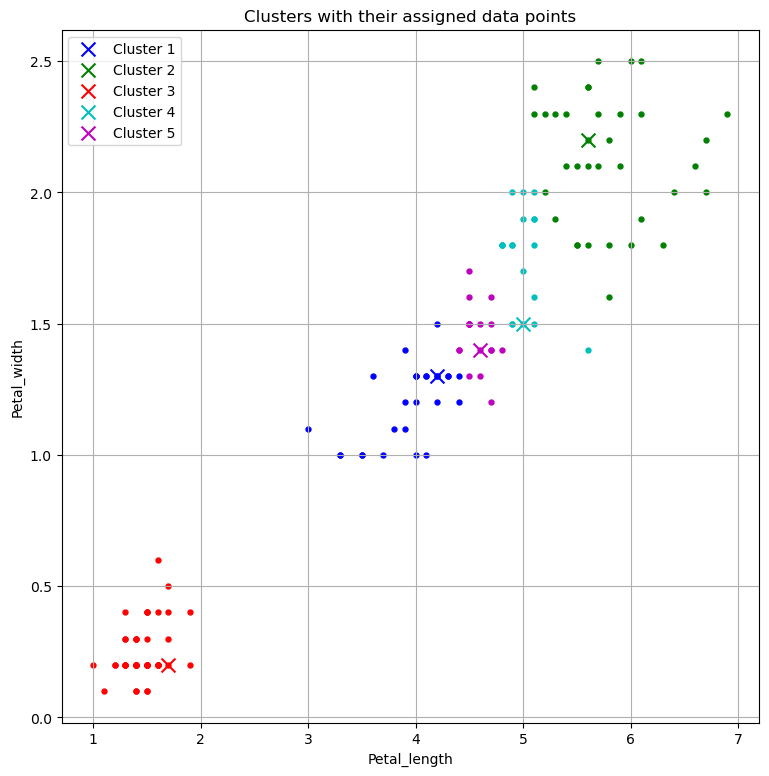

In [21]:
def plot_clusters(data, b, means):
    '''
    plot the means and their assigned data points as described by b
    '''
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
    
    # determine number of clusters
    k_means = means.shape[0]

    # create a new figure
    plt.figure(figsize=(9, 9))

    # loop over each individual cluster
    for cluster_index in range(k_means):
        cluster_points = get_cluster_points(data, b, cluster_index)

        # assign a random color to that cluster
        assert cluster_index <= len(colors), 'more clusters than available colors'
        color = colors[cluster_index]
        
        # plot the cluster mean
        plt.scatter(means[cluster_index, 0], means[cluster_index, 1], c=color, marker='x', label=f'Cluster {cluster_index + 1}', s=100)
        
        # plot the assigned data points to that cluster
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], c=color, marker='.', s=50)

    plt.title('Clusters with their assigned data points')
    plt.xlabel('Petal_length')
    plt.ylabel('Petal_width')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_clusters(data, test_b_matrix, test_means_matrix)

### Assignment 7: K-means

Combine all these functions into a general `k`-means function for some `data` set, as described by the pseudo-code below:

* Randomly initialize all $\mu_j$, with $j = 1, \dots, k$
* Until $\mu$ converges:
    * For all $x^i$, with $i = 1, \dots, m$
        * $b^i_j \leftarrow \left\{\begin{array}{ll} 1 & if\ dist(x^i,  \mu_j) \ =\ min_d\ dist(x^i, \mu_d)\\ 
            0 & otherwise \\ \end{array}\right.$
    * For all $\mu_j$, with $j = 1, \dots, k$
        * $\mu_j \leftarrow \sum_i b^i_j x^i / \sum_i b^i_j$

When converged, the `kmeans` function should return the matrix of converged means `mu`.


In [27]:
def kmeans(data, k):
    '''
    Cluster unsupervised data using the k-means algorithm
    '''
    
    # randomly initialize k means, selecting random k points
    means = init_clusters(data, k)

    # initialize means_new by running the first iteration  
    b = cluster_assignment(data, means)
    means_new = compute_means(data, b)
    
    while not is_converged(means, means_new):
        
        # reset value before start of iteration
        means = means_new
        
        # Compute the one-hot encoded matrix B containing the
        # assignments of data points to their nearest cluster means
        b = cluster_assignment(data, means)
        
        # Compute the new mean vectors of all clusters
        means_new = compute_means(data, b)

    return means_new
        

In [28]:
assert kmeans(data, 3).shape == (3, data.shape[1]), "Your output has the incorrect shape."
assert kmeans(data, 12).shape == (12, data.shape[1]), "Your output has the incorrect shape."
assert np.all([mean in np.array([[1, 3, 0], [0, 2, 3], [1, 0, 1]]) for mean in kmeans(np.array([[1, 3, 0], [0, 2, 3], [1, 0, 1]]), 3)]), "Your function assigns incorrect means"
print("Basic tests passed. Because the result of kmeans depends on the specific random initialization, this function cannot be fully tested. Passing these tests does not mean that kmeans is correct. Checking the steps of kmeans will be the next assignment, where you ensure your function actually works.")

Basic tests passed. Because the result of kmeans depends on the specific random initialization, this function cannot be fully tested. Passing these tests does not mean that kmeans is correct. Checking the steps of kmeans will be the next assignment, where you ensure your function actually works.


### Assignment 8: Inspecting the steps of k-means

For this next part of the assignment, we're going to take a look at the steps of the k-means algorithm. To start with, copy the contents of your  `kmeans` function into the cell below (just the contents, so leave out the function definition line). The code should use a fixed value of $k=3$ and the data set will of course be the Iris data set. Here we'll modify the code of the function to show plots of intermediate steps and see the progress of the algorithm.

In order to be able to inspect the intermediate results of the k-means algorithm, you will need to plot the clusters and assigned points at different stages of the k-means algorithm, *before* it has converged. You should not plot *all* the steps though, as there will be too many. The most informative plots are probably the first few steps of k-means and then also the final converged result, but you may select your own intermediate steps. Modify your code to plot 4 specific intermediate steps of *k-means* and label each of the plots accordingly.

Check that all these steps look correct before continuing the assignment, as this will be the easiest way to visually ensure k-means is actually doing the right steps each iteration.

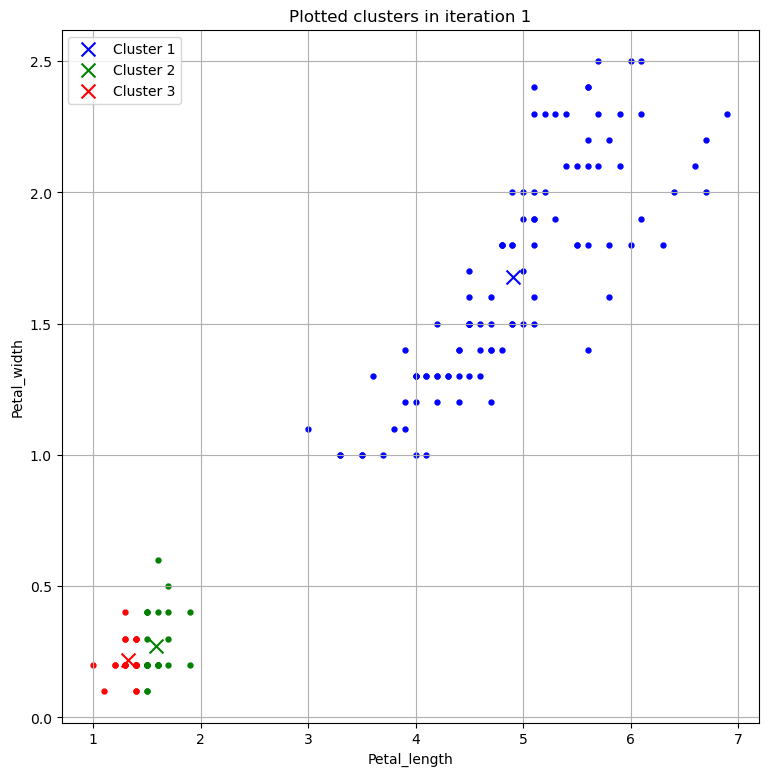

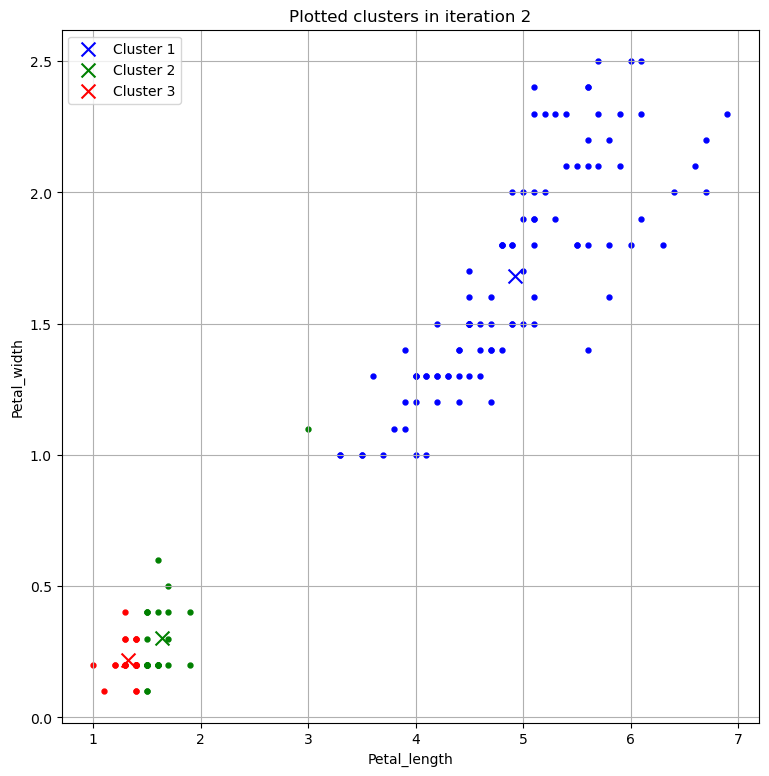

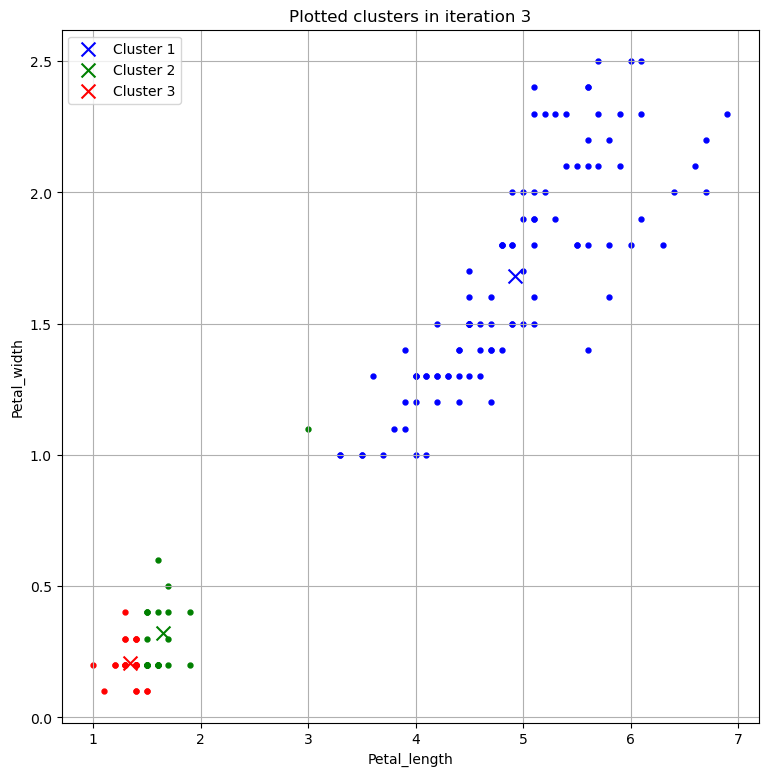

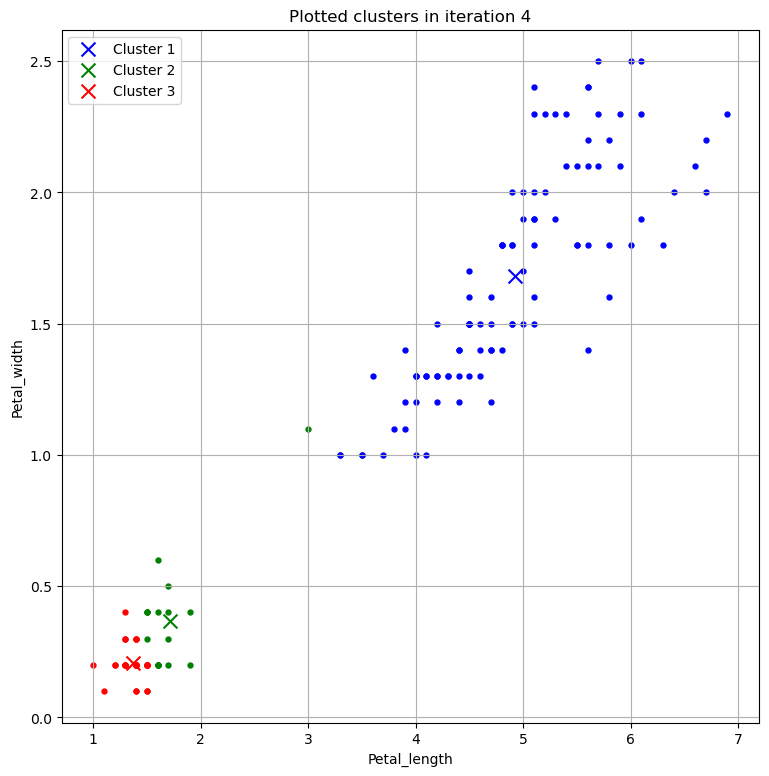

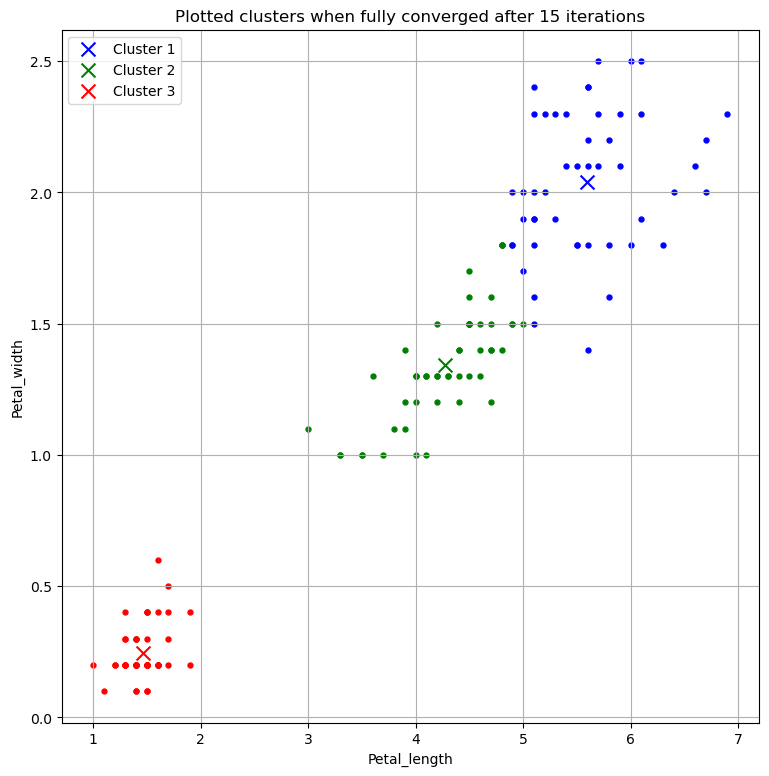

In [36]:
# set initial number of clusters
k = 3

# initialize iteration count
count = 1

def plot_clusters_labeled(data, b, means, label):
    '''
    plot the means and their assigned data points
    including label to indicate which iteration it reflects
    '''
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
    
    # determine number of clusters
    k_means = means.shape[0]

    # create a new figure
    plt.figure(figsize=(9, 9))

    # loop over each individual cluster
    for cluster_index in range(k_means):
        cluster_points = get_cluster_points(data, b, cluster_index)

        # assign a random color to that cluster
        assert cluster_index <= len(colors), 'more clusters than available colors'
        color = colors[cluster_index]
        
        # plot the cluster mean
        plt.scatter(means[cluster_index, 0], means[cluster_index, 1], c=color, marker='x', label=f'Cluster {cluster_index + 1}', s=100)
        
        # plot the assigned data points to that cluster
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], c=color, marker='.', s=50)      

    plt.title(label)
    plt.xlabel('Petal_length')
    plt.ylabel('Petal_width')
    plt.legend()
    plt.grid(True)
    plt.show()

# randomly initialize k means, selecting random k points
means = init_clusters(data, k)

# initialize means_new by running the first iteration  
b = cluster_assignment(data, means)
means_new = compute_means(data, b)

# plotting the first iteration of k-means
label = f'Plotted clusters in iteration {count}'
plot_clusters_labeled(data, b, means_new, label)

# keep recalculating new means until they remain the same
while not is_converged(means, means_new):
   
    # adapt counter for iterations
    count += 1
    
    # reset value before start of iteration
    means = means_new
    
    # Compute the one-hot encoded matrix B containing the
    # assignments of data points to their nearest cluster means
    b = cluster_assignment(data, means)

    # Compute the new mean vectors of all clusters
    means_new = compute_means(data, b)
    
    # plotting the next first few steps of k-means
    if count <= 4:
        label = f'Plotted clusters in iteration {count}'
        plot_clusters_labeled(data, b, means_new, label)

# plotting the final converged result
label = f'Plotted clusters when fully converged after {count} iterations'
plot_clusters_labeled(data, b, means, label)


### Assignment 9: Elbow method

Now that you have a working k-means implementation, we can answer the last remaining question in this assignment:

* What is the most likely number of cluster $k$ for this data set?

One way to answer this question is using the elbow method, as described in the theory videos. Complete the following 3 functions below to create an elbow graph:

1. `cost`: This need *not necessarily* be the same cost function as defined in the theory videos. Write a sensible cost that should be minimized with each step of the k-means algorithm.
2. `average_cost`: This function should repeatedly try and fit `k` clusters to the data, and compute the resulting converged cost. As this cost will depend on the cluster initialization, the process should be repeated `n` times and the cost averaged.
3. `create_elbow_plot`: This function should compute the average cost from $1$ to `max_k`, using the provided `data`, and create the corresponding elbow plot.

Finally, call `create_elbow_plot` with a `max_k` of $10$.

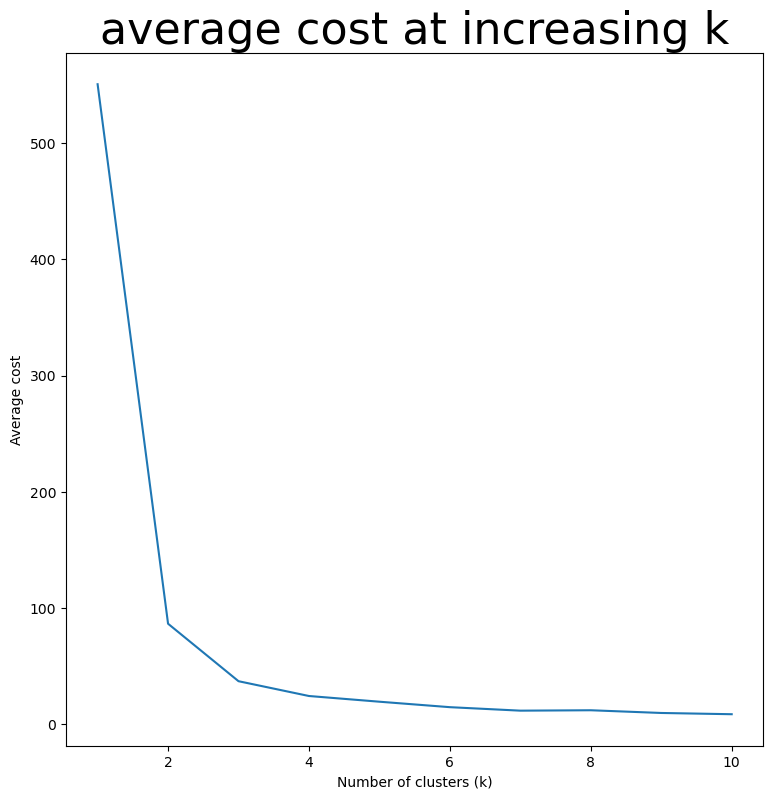

In [39]:
def cost(data, means, b):
    '''
    Calculate cost based on function:
    sum(i=1-m) sum(j=1-k) b_i_j ((x_i - mu_j)^2)
    m = number samples, k = number clusters, b = one-hot encoded matrix
    x_i = sample i, mu_j = mean of cluster j  
    '''
    cost = 0.0
    
    # loop over all the samples
    for i in range(data.shape[0]):
        
        # for each sample, loop over all clusters
        for j in range(b.shape[1]):
            
            #  boolean mask the sample
            if b[i, j] == 1:
                
                # add cost of this sample to total
                cost += np.sum(np.square(data[i] - means[j]))
    
    return cost   

def average_cost(data, k, n):
    '''
    returns average cost
    since individual costs vary due to their dependence on the cluster
    initialization, the average is taken over n runs
    '''
    cost_cumul = 0.0
    
    # repeat n times the cost calculation 
    for run in range(n):
        
        # calculate new means
        means = kmeans(data, k)

        # re-assign samples to the clusters  
        b = cluster_assignment(data, means)
        
        # add costs based on new means and assignments
        cost_cumul += cost(data, means, b)
    
    return cost_cumul / n 

def create_elbow_plot(data, max_k, n=10):
    '''
    compute the average cost from 1 to max_k
    and create the corresponding elbow plot
    '''
    # prepares both axes of the plot
    k_list = list(range(1, max_k + 1))
    cost_list = []
    
    for k in k_list:
        cost_list.append(average_cost(data, k, n))

    # Plot with all the results
    plt.figure(figsize=(9,9))
    plt.plot(k_list, cost_list)
    plt.title('average cost at increasing k', fontsize=32)
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Average cost')
    plt.show()
    
create_elbow_plot(data, 10, 10)


**Q1. What do you think is the most likely value for $k$ in the Iris data set? Explain your answer.**

It appears that the most likely value for k is 3. There is a clear elbow at that spot, a point where the cost starts to decrease at a much slower rate. Adding more clusters after k= 3 would not significantly improve the fit within the clusters.